# Imports

In [ ]:
# !pip install seaborn

In [23]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler , TensorBoard
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras import backend as K
import datetime
import shutil
# from skimage import morphology, feature, segmentation, measure, io, color
# from skimage.filters import sobel
import pdb
import imageio
from scipy import misc
import scipy.ndimage as ndimage
from sklearn.model_selection import KFold
from skimage.transform import resize
from skimage import io, color
import cv2
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler , EarlyStopping
import pandas as pd
import re
from collections import defaultdict
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns

%run generator.ipynb
%run model.ipynb

# import warnings
# warnings.filterwarnings('ignore')
# from google.colab.patches import cv2_imshow  # Only required in Google Colab
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="imageio")

# Data Generator

In [ ]:

def summarize_results(values, name="Loss"):
    """Print mean and 95% CI, and return results for later use."""
    mean_val = np.mean(values)
    lower = np.percentile(values, 2.5)
    upper = np.percentile(values, 97.5)

    print(f"{name}: Mean = {mean_val:.4f}, 95% CI = [{lower:.4f}, {upper:.4f}]")
    return mean_val, lower, upper

In [8]:
class CustomDataGenerator(tf.keras.utils.Sequence):

    def extract_main_name(self ,filename):
        parts = filename.split('_')
        for i, part in enumerate(parts):
            if re.fullmatch(r'\d{3}', part):  # Find the first 3-digit part
                return '_'.join(parts[:i])    # Main name is everything before that
        return None  # If no tile index found

    def main_name_ends_with_1(self , filename):
        main_name = self.extract_main_name(filename)
        return main_name is not None and main_name.endswith('1')

    def __init__(self, data_dir, label_dir, batch_size, dim, data_files=None, label_files=None , n_channels=1,
                 n_classes_or_output_dim=1 , shuffle=True, augmentor=None ):
        'Initialization'
        self.dim = dim  # e.g., (256, 256)
        self.batch_size = batch_size
        self.n_channels = n_channels  # Will be 1 for grayscale
        self.n_classes_or_output_dim = n_classes_or_output_dim  # e.g., 1 for regression output
        self.shuffle = shuffle
        self.augmentor = augmentor  # Your ImageDataGenerator instance
        self.target_size=self.dim[0]


        if data_files is None and label_files is None:
            self.data_dir = data_dir  # Directory containing input images
            self.label_dir = label_dir  # Directory containing label images
            self.filtered_filenames = sorted([
                f for f in os.listdir(data_dir)
                if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')) #and self.main_name_ends_with_1(f)
            ])
            self.data_files = [os.path.join(data_dir, f) for f in self.filtered_filenames]
            self.label_files = [os.path.join(label_dir, f) for f in self.filtered_filenames]
            # print("label files;",self.label_files[:5])
        else:
            self.data_files = data_files
            self.label_files = label_files

        # Get list of all image files in the directories
        # self.data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir)
        #                         if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])
        # self.label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir)
        #                          if f.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))])

        # Verify that we have matching pairs of data and label files
        assert len(self.data_files) == len(self.label_files), "Number of input and label images must match"

        self.indexes = np.arange(len(self.data_files))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        try:
            # Calculate safe indexes
            start_idx = index * self.batch_size
            end_idx = min((index + 1) * self.batch_size, len(self.indexes))
            batch_indexes = self.indexes[start_idx:end_idx]

            # Ensure we don't return empty batches
            if len(batch_indexes) == 0:
                batch_indexes = self.indexes[-self.batch_size:]  # Take last complete batch

            X, y = self.__data_generation(batch_indexes)

            if self.augmentor:
                # augmented_X = np.empty_like(X)
                # augmented_y = np.empty_like(y)

                batch_iter = self.augmentor.flow(X.astype('float32'),
                                  y,
                                  batch_size = self.batch_size,
                                  shuffle=False
                                  )
                # img_aug = self.augmentor.standardize(img_aug)
                img_aug , lbl_aug = next(batch_iter)
                # augmented_X = img_aug
                # augmented_y = lbl_aug
                # print(img_aug.shape , lbl_aug.shape )
                return img_aug, lbl_aug
            else:
                # print('batch returned')
                return X, y
        except Exception as e:
            raise

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def __data_generation(self, batch_indexes):
        X = np.empty((len(batch_indexes), *self.dim, self.n_channels), dtype=np.float32)
        y = np.empty((len(batch_indexes), *self.dim, 1), dtype=np.float32)  # Single channel output
        for i, idx in enumerate(batch_indexes):
            # Load and process input image
            img = cv2.imread(self.data_files[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            lbl = cv2.imread(self.label_files[idx])
            lbl = cv2.cvtColor(lbl, cv2.COLOR_BGR2GRAY)
            # print('img index: ', idx , ' image shape: ', img.shape , lbl.shape)
            # print('img values: ',np.min(img), np.max(img ))

            height, width = img.shape[:2]
            # print(lbl.shape)
            # print(self.dim)
            if (height, width) != (self.dim[0] , self.dim[1]):
                pad_top = (self.target_size - height) // 2
                pad_bottom = self.target_size - height - pad_top
                pad_left = (self.target_size - width) // 2
                pad_right = self.target_size - width - pad_left

                img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)
                lbl = cv2.copyMakeBorder(lbl, pad_top, pad_bottom, pad_left, pad_right,  borderType=cv2.BORDER_CONSTANT, value=0)
            # Process labels
            img =img[:, :, np.newaxis]
            lbl = lbl[:, :, np.newaxis]
            # print('lable  values: ' ,np.min(lbl), np.max(lbl) , ' uniq vals: ', np.unique(lbl))

            X[i,] = img
            y[i,] = lbl


        return  X,y

## Example usage

train batch length:  6633 test batch length:  1404
test_gen data shape:  (4, 256, 256, 1) (4, 256, 256, 1) label min, mean, max :  0.0 0.50811767578125 100.0


C:\Users\narges\AppData\Local\Temp\ipykernel_27400\2908956172.py:5: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,


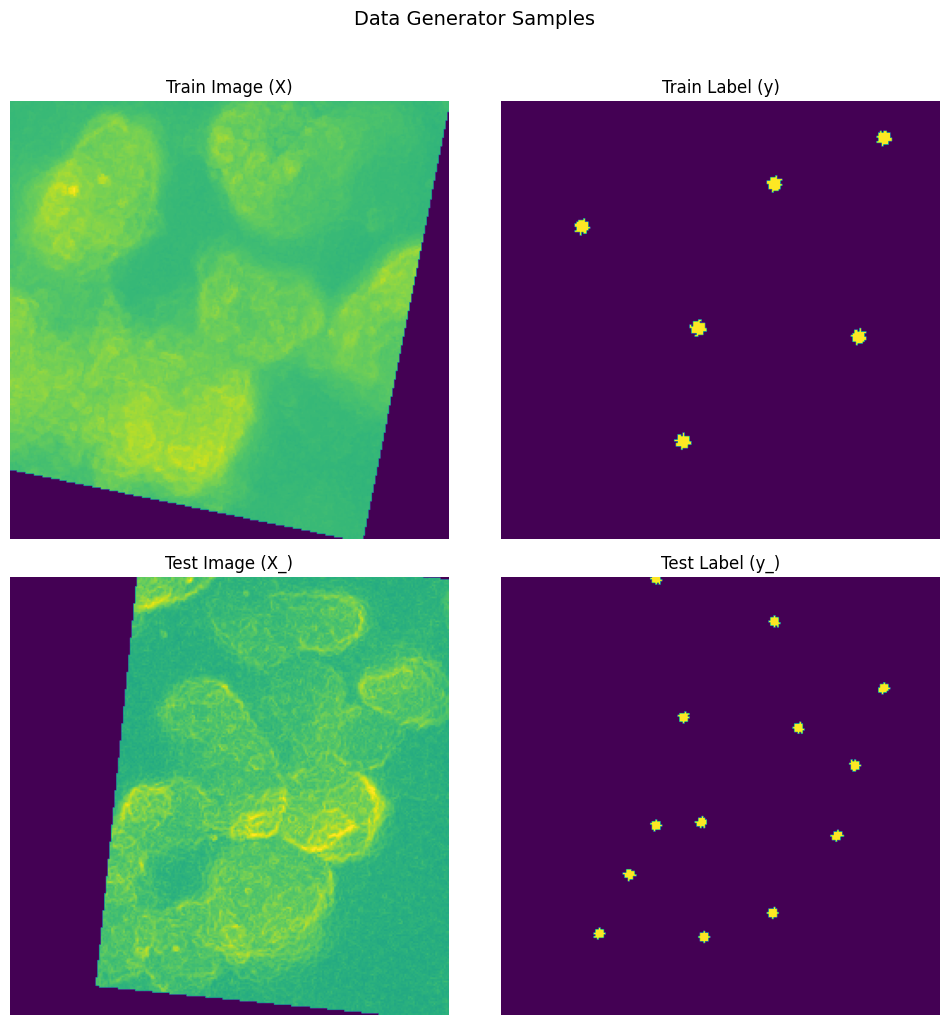

In [9]:
base_address= '../pythonProject3/Compelet_dataset_preprocessing/datasets/'
train_img_path = base_address + 'train/dic_tiles_256/'
train_centroids_img_path = base_address + 'train/gt_tiles_256_green/'

test_img_path = base_address + 'test/dic_tiles_256/'
test_centroids_img_path = base_address + 'test/gt_tiles_256_green/'

datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range = 0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.3,  # randomly shift images vertically (fraction of total height)
        zoom_range = 0.3,
        shear_range = 0.,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True, # randomly flip images
        fill_mode = 'constant',
        dim_ordering = 'tf')
train_generator = CustomDataGenerator(
    data_dir=train_img_path,
    label_dir=train_centroids_img_path,
    batch_size=4,
    dim=(256, 256),  # Target size
    data_files=None,
    label_files=None ,
    n_channels=1,     # Grayscale
    shuffle=True,
    augmentor=None  # Optional
)
test_generator = CustomDataGenerator(
    data_dir=test_img_path,
    label_dir=test_centroids_img_path,
    batch_size=4,
    dim=(256, 256),  # Target size
    data_files=None,
    label_files=None ,
    n_channels=1,     # Grayscale
    shuffle=True,
    augmentor=datagen  # Optional
)
print('train batch length: ' , len(train_generator) , 'test batch length: ' , len(test_generator))

for i in range(len(test_generator)):
    # tr_X, tr_y  = train_generator[i]
    te_X_, te_y_  = test_generator[i]
    # print('train_gen data shape: ' ,tr_X.shape , tr_y.shape , 'label img min, mean, max : ', np.min(tr_y[0]) , np.mean(tr_y[0]), np.max(tr_y[0]))
    print('test_gen data shape: ' ,te_X_.shape , te_y_.shape , 'label min, mean, max : ', np.min(te_y_[0]) , np.mean(te_y_[0]), np.max(te_y_[0]))
    # y = y.squeeze(-1)
    # squeezed_y =  np.squeeze(y)

    # print(squeezed_y.shape)

    # if y[i].ndim == 3:  # Check if 3D (H,W,3 or H,W,1)
    #         y[i] = np.mean(y[i], axis=-1)


    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot training samples
    axs[0, 0].imshow(te_X_[0])
    axs[0, 0].set_title('Train Image (X)')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(te_y_[0])
    axs[0, 1].set_title('Train Label (y)')
    axs[0, 1].axis('off')

    # Plot testing samples
    axs[1, 0].imshow(te_X_[3])
    axs[1, 0].set_title('Test Image (X_)')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(te_y_[3])
    axs[1, 1].set_title('Test Label (y_)')
    axs[1, 1].axis('off')

    plt.suptitle('Data Generator Samples', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
    break

# U-Net & Light-U-Net network

In [10]:

# tf.config.run_functions_eagerly(True)
def step_decay(epoch):
    step = 3
    lrate = 1e0
    num = epoch // step
    if num % 3 == 0:
        lrate = 5e-1
    elif num % 3 == 1:
        lrate = 5e-2
    else:
        lrate = 5e-3
        #lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
    print('Learning rate for epoch {} is {}.'.format(epoch + 1, lrate))
    return float(lrate)


np.float = float
def unet_train_(train_files, train_anno_files , test_files, test_anno_files  , epochs):

    file_name=  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # print("train set size : ",len(train_data) , " test set size : " , len(val_data) )


    print('-'*30)
    print('Creating and compiling the fully convolutional regression networks.')
    print('-'*30)

    model = build_unet_model(input_dim = (256,256,1))
    opt = tf.keras.optimizers.RMSprop(learning_rate=1e-4, clipnorm=1.0)

    model.compile(optimizer=opt, loss='mse')

    change_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )

    model_checkpoint = ModelCheckpoint('./checkpoints_bootstrap/U_Net/U_Net_256_image'+file_name+'.hdf5', monitor='val_loss', save_best_only=True)
    model.summary()
    print('...Fitting model...')
    print('-'*30)
    # change_lr = LearningRateScheduler(step_decay)
    batch_size = 4
    input_dim_hw = (256, 256) # Height, Width
    n_channels_img = 1

    early_stop = EarlyStopping(
                monitor='val_loss',
                patience=5,          # stop if val_loss doesn’t improve for 5 epochs
                restore_best_weights=True,
                verbose=1
            )
    datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range = 0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.3,  # randomly shift images vertically (fraction of total height)
        zoom_range = 0.3,
        shear_range = 0.,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True, # randomly flip images
        fill_mode = 'constant',
        dim_ordering = 'tf')

    train_generator = CustomDataGenerator(
        data_dir=None,
        label_dir=None,
        batch_size=batch_size,
        dim=input_dim_hw,  # Target size
        data_files=train_files,
        label_files=train_anno_files ,
        n_channels=n_channels_img,  # Grayscale
        shuffle=True,
        augmentor=datagen  # Optional
    )

    test_generator = CustomDataGenerator(
        data_dir=None,
        label_dir=None,
        batch_size=batch_size,
        dim=(256, 256),  # Target size
        data_files=test_files,
        label_files=test_anno_files ,
        n_channels=1,     # Grayscale
        shuffle=True,
        augmentor=None  # Optional
)
    with tf.device('/GPU:0'):
        history = model.fit(train_generator, # Use model.fit with generators
                            validation_data=test_generator,
                            epochs=epochs,
                            callbacks=[model_checkpoint, change_lr , early_stop],
                            # validation_data=validation_generator, # If you have one
                            workers=8, # Number of worker threads for parallel data loading
                            # use_multiprocessing=True, # If True, use process-based threading
                            # max_queue_size=32
                           )
    return history , model

In [33]:

# tf.config.run_functions_eagerly(True)
def step_decay(epoch):
    step = 3
    lrate = 1e0
    num = epoch // step
    if num % 3 == 0:
        lrate = 5e-1
    elif num % 3 == 1:
        lrate = 5e-2
    else:
        lrate = 5e-3
        #lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
    print('Learning rate for epoch {} is {}.'.format(epoch + 1, lrate))
    return float(lrate)


np.float = float
def light_unet_train_(train_files, train_anno_files , test_files, test_anno_files  , epochs):

    file_name=  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # print("train set size : ",len(train_data) , " test set size : " , len(val_data) )


    print('-'*30)
    print('Creating and compiling the fully convolutional regression networks.')
    print('-'*30)

    model = buildModel_Light_U_net(input_dim = (256,256,1))
    opt = tf.keras.optimizers.RMSprop(learning_rate=1e-4, clipnorm=1.0)

    model.compile(optimizer=opt, loss='mse')

    change_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )

    model_checkpoint = ModelCheckpoint('./checkpoints_bootstrap/Light_U_Net/Light_U_Net_256_image'+file_name+'.hdf5', monitor='val_loss', save_best_only=True)
    model.summary()
    print('...Fitting model...')
    print('-'*30)
    # change_lr = LearningRateScheduler(step_decay)
    batch_size = 4
    input_dim_hw = (256, 256) # Height, Width
    n_channels_img = 1

    early_stop = EarlyStopping(
                monitor='val_loss',
                patience=5,          # stop if val_loss doesn’t improve for 5 epochs
                restore_best_weights=True,
                verbose=1
            )
    datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range = 0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.3,  # randomly shift images vertically (fraction of total height)
        zoom_range = 0.3,
        shear_range = 0.,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True, # randomly flip images
        fill_mode = 'constant',
        dim_ordering = 'tf')

    train_generator = CustomDataGenerator(
        data_dir=None,
        label_dir=None,
        batch_size=batch_size,
        dim=input_dim_hw,  # Target size
        data_files=train_files,
        label_files=train_anno_files ,
        n_channels=n_channels_img,  # Grayscale
        shuffle=True,
        augmentor=datagen  # Optional
    )

    test_generator = CustomDataGenerator(
        data_dir=None,
        label_dir=None,
        batch_size=batch_size,
        dim=(256, 256),  # Target size
        data_files=test_files,
        label_files=test_anno_files ,
        n_channels=1,     # Grayscale
        shuffle=True,
        augmentor=None  # Optional
)
    with tf.device('/GPU:0'):
        history = model.fit(train_generator, # Use model.fit with generators
                            validation_data=test_generator,
                            epochs=epochs,
                            callbacks=[model_checkpoint, change_lr , early_stop],
                            # validation_data=validation_generator, # If you have one
                            workers=8, # Number of worker threads for parallel data loading
                            # use_multiprocessing=True, # If True, use process-based threading
                            # max_queue_size=32
                           )
    return history , model

# Bootstrap Functions

In [11]:

def all_tiles_of_sample(animal_name , all_tiles , tiles_path ):
    tiles = []
    pattern = re.compile(f"{animal_name}_\d+_x(\d+)_y(\d+)\.png")
    for filename in all_tiles:
        match = pattern.match(filename)
        if match:
            # x = int(match.group(1))
            # y = int(match.group(2))
            tile_path = os.path.join(tiles_path, filename)
            # print(tile_path)
            # tile_img = cv2.imread(tile_path)
            if tile_path is not None:
                tiles.append(  tile_path)
            else:
                print(f"Warning: Couldn't load {tile_path}, skipping.")
    return tiles

In [12]:

# ---- Bootstrap Train/Test Split ----
def bootstrap_split(category_samples ,  train_ratio=0.8):
    """Returns (train_samples, test_samples) using bootstrap sampling."""
    n = len(category_samples)
    train_count = int(n * train_ratio)
    train_images = random.choices(category_samples, k=train_count)  # with replacement
    test_images = [s for s in category_samples if s not in train_images]
     # Derive label paths

    return train_images, test_images


In [13]:

# ---- Group samples by ID ----
def Group_samples_by_ID(all_dics,all_dic_tiles , all_regions_tiles , dic_tiles_path, regions_tiles_path):
    dic_tiles_by_sample = defaultdict(list)
    regions_tiles_by_sample= defaultdict(list)
    for sample in all_dics:
        sample_id = sample.split('.')[0]
        dic_tiles_by_sample[sample_id] = all_tiles_of_sample(sample_id, all_dic_tiles, dic_tiles_path)
        regions_tiles_by_sample[sample_id] = all_tiles_of_sample(sample_id, all_regions_tiles, regions_tiles_path)

    # ---- Categorize samples ----
    # Assuming filenames contain category info like "sample_low_01.png"
    categories = {"low": [], "medium": [], "high": []}
    for sample in all_dics:
        sample_id = sample.split('.')[0]
        if sample_id[-1]=='3':
            categories["low"].append(sample_id)
        elif sample_id[-1]=='2':
            categories["medium"].append(sample_id)
        elif sample_id[-1]=='1':
            categories["high"].append(sample_id)
        else:
            print(f"⚠️ Warning: Could not determine category for {sample_id}")
    return dic_tiles_by_sample , regions_tiles_by_sample , categories

In [14]:
def prepare_dataset(categories , dic_tiles_by_sample , regions_tiles_by_sample  ):
    train_samples = []
    test_samples = []
    # Ensure all categories appear in train
    for cat, samples in categories.items():
        if len(samples) == 0:
            print(f"⚠️ No samples found for category '{cat}'")
            continue
        print( cat, len(samples) )
        t_train, t_test = bootstrap_split(samples )
        train_samples.extend(t_train)
        test_samples.extend(t_test)

    # ---- Build train/test tiles ----
    train_tiles = []
    test_tiles = []
    train_labels_tiles = []
    test_labels_tiles = []

    for sample_id in train_samples:
        if sample_id in dic_tiles_by_sample:
            train_tiles.extend(dic_tiles_by_sample[sample_id])
            train_labels_tiles.extend(regions_tiles_by_sample[sample_id])

    for sample_id in test_samples:
        if sample_id in dic_tiles_by_sample:
            test_tiles.extend(dic_tiles_by_sample[sample_id])
            test_labels_tiles.extend(regions_tiles_by_sample[sample_id])


    print(f"✅ Train samples: {len(train_samples)} ({', '.join(categories.keys())})")
    print(f"✅ Test samples: {len(test_samples)}")
    print(f"✅ Train tiles: {len(train_tiles)}, Test tiles: {len(test_tiles)}")
    return train_tiles, train_labels_tiles ,  test_tiles , test_labels_tiles

In [35]:

# ---- Paths ----
based_add = './Dataset/'
dic_path = based_add + 'Train_&_Test/original_rgc/'
dic_tiles_path = based_add + 'Train_&_Test/dic_tiles_256/'
regions_tiles_path= based_add + 'Train_&_Test/regions_tiles_256/'

# ---- Get all files ----
all_dics = glob.glob(os.path.join(dic_path, "*.png"))
all_dic_tiles = glob.glob(os.path.join(dic_tiles_path, "*.png"))
all_regions_tiles= glob.glob(os.path.join(regions_tiles_path, "*.png"))

# ---- Clean paths -----
all_dic_tiles = [os.path.basename(i) for i in all_dic_tiles]
all_dics = [os.path.basename(i) for i in all_dics]
all_regions_tiles = [os.path.basename(i) for i in all_regions_tiles]



# --- Buildup the dataset settings ---

dic_tiles_by_sample , regions_tiles_by_sample , categories = Group_samples_by_ID(all_dics,all_dic_tiles , all_regions_tiles , dic_tiles_path, regions_tiles_path)

## Test the bootstrap data generators

low 303
medium 309
high 281
✅ Train samples: 713 (low, medium, high)
✅ Test samples: 378
✅ Train tiles: 25668, Test tiles: 13608
25668 25668 13608 13608
train batch length:  6417 test batch length:  3402
test_gen data shape:  (4, 256, 256, 1) (4, 256, 256, 1) label min, mean, max :  0.0 23.509368896484375 255.0


C:\Users\narges\AppData\Local\Temp\ipykernel_27400\2908956172.py:5: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,


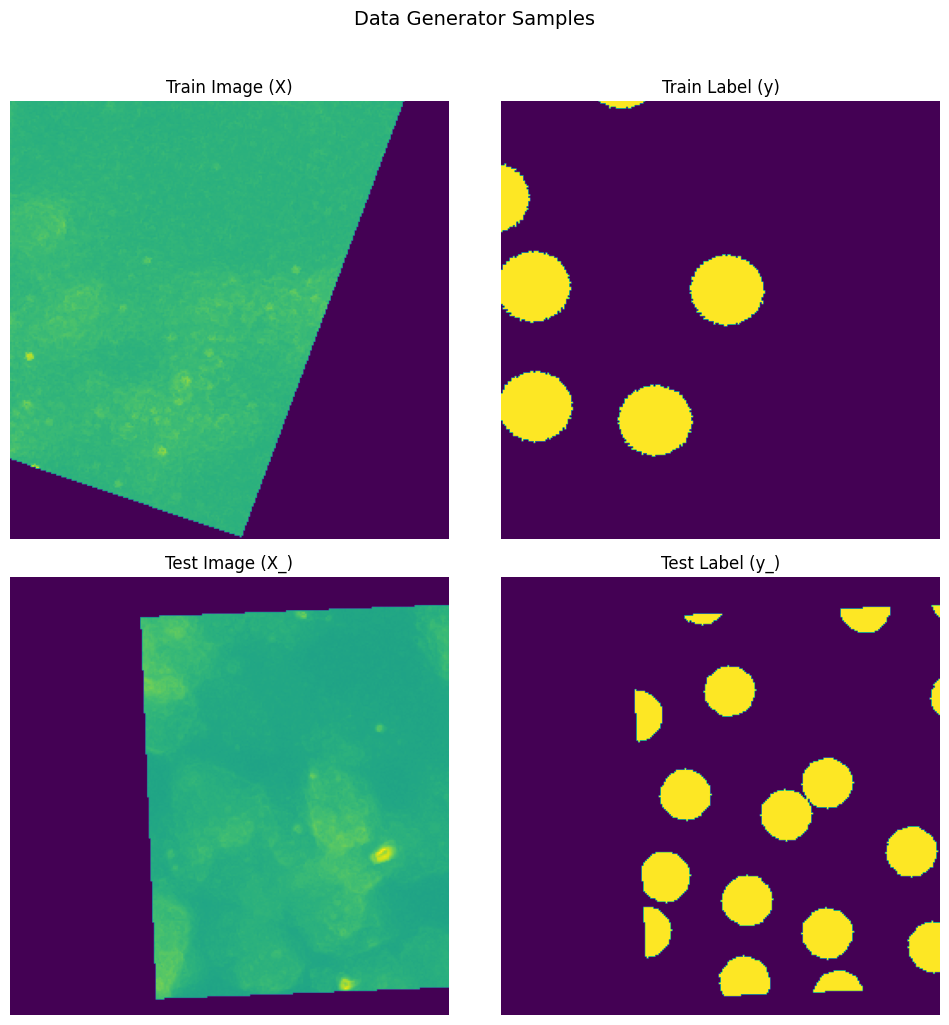

In [16]:
train_tiles, train_labels_tiles ,  test_tiles , test_labels_tiles = prepare_dataset(categories, dic_tiles_by_sample , regions_tiles_by_sample )
print(len(train_tiles) , len(train_labels_tiles) , len(test_tiles) , len(test_labels_tiles))
X_train = np.array(train_tiles)
X_test = np.array(test_tiles)
# Load your ground truth labels accordingly here ⬇️
y_train =  np.array(train_labels_tiles)  # <-- replace with actual GT
y_test =  np.array(test_labels_tiles)   # <-- replace with actual GT


datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range = 0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.3,  # randomly shift images vertically (fraction of total height)
        zoom_range = 0.3,
        shear_range = 0.,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True, # randomly flip images
        fill_mode = 'constant',
        dim_ordering = 'tf')
train_generator = CustomDataGenerator(
    data_dir=None,
    label_dir=None,
    batch_size=4,
    dim=(256, 256),  # Target size
    data_files=X_train,
    label_files=y_train ,
    n_channels=1,     # Grayscale
    shuffle=True,
    augmentor=None  # Optional
)
test_generator = CustomDataGenerator(
    data_dir=None,
    label_dir=None,
    batch_size=4,
    dim=(256, 256),  # Target size
    data_files=X_test,
    label_files=y_test ,
    n_channels=1,     # Grayscale
    shuffle=True,
    augmentor=datagen  # Optional
)
print('train batch length: ' , len(train_generator) , 'test batch length: ' , len(test_generator))

for i in range(len(test_generator)):
    # tr_X, tr_y  = train_generator[i]
    te_X_, te_y_  = test_generator[i]
    # print('train_gen data shape: ' ,tr_X.shape , tr_y.shape , 'label img min, mean, max : ', np.min(tr_y[0]) , np.mean(tr_y[0]), np.max(tr_y[0]))
    print('test_gen data shape: ' ,te_X_.shape , te_y_.shape , 'label min, mean, max : ', np.min(te_y_[0]) , np.mean(te_y_[0]), np.max(te_y_[0]))
    # y = y.squeeze(-1)
    # squeezed_y =  np.squeeze(y)

    # print(squeezed_y.shape)

    # if y[i].ndim == 3:  # Check if 3D (H,W,3 or H,W,1)
    #         y[i] = np.mean(y[i], axis=-1)


    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot training samples
    axs[0, 0].imshow(te_X_[0])
    axs[0, 0].set_title('Train Image (X)')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(te_y_[0])
    axs[0, 1].set_title('Train Label (y)')
    axs[0, 1].axis('off')

    # Plot testing samples
    axs[1, 0].imshow(te_X_[3])
    axs[1, 0].set_title('Test Image (X_)')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(te_y_[3])
    axs[1, 1].set_title('Test Label (y_)')
    axs[1, 1].axis('off')

    plt.suptitle('Data Generator Samples', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
    break

## UNet

# =============================
# Bootstrap Training Loop
# =============================

In [17]:

"""
Perform bootstrap training B times, track val_loss each run.
model_class: function returning a compiled model.
"""

B=100
epochs=10

unet_all_val_loss = []
unet_all_losses= []
for b in range(B):
    print(f"\n🔁 Bootstrap iteration {b+1}/{B}")

    train_tiles, train_labels_tiles ,  test_tiles , test_labels_tiles = prepare_dataset(categories, dic_tiles_by_sample , regions_tiles_by_sample )
    print(len(train_tiles) , len(train_labels_tiles) , len(test_tiles) , len(test_labels_tiles))
    X_train = np.array(train_tiles)
    X_test = np.array(test_tiles)
    # Load your ground truth labels accordingly here ⬇️
    y_train =  np.array(train_labels_tiles)  # <-- replace with actual GT
    y_test =  np.array(test_labels_tiles)   # <-- replace with actual GT

    # Create and train model
    history , model  =unet_train_(X_train, y_train , X_test, y_test  ,epochs )

    # Track final val_loss
    val_loss = history.history['val_loss'][-1]
    loss = history.history['loss'][-1]
    print(f"📉 Final val_loss (bootstrap {b+1}): {val_loss:.4f}")
    unet_all_val_loss.append(val_loss)
    unet_all_losses.append(loss)




🔁 Bootstrap iteration 1/100
low 303
medium 309
high 281
✅ Train samples: 713 (low, medium, high)
✅ Test samples: 414
✅ Train tiles: 25668, Test tiles: 14904
25668 25668 14904 14904
------------------------------
Creating and compiling the fully convolutional regression networks.
------------------------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]  

C:\Users\narges\AppData\Local\Temp\ipykernel_27400\2908956172.py:5: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,


6417/6417 [==============================] - 813s 126ms/step - loss: 5596.5342 - val_loss: 7729.0830
Epoch 2/10
6417/6417 [==============================] - 806s 126ms/step - loss: 5008.5435 - val_loss: 8307.0693
Epoch 3/10
6417/6417 [==============================] - 805s 126ms/step - loss: 4993.5903 - val_loss: 7740.3882
Epoch 4/10
6417/6417 [==============================] - 805s 126ms/step - loss: 4977.4067 - val_loss: 7511.7441
Epoch 5/10
6417/6417 [==============================] - 803s 125ms/step - loss: 4964.2119 - val_loss: 8967.7480
Epoch 6/10
6417/6417 [==============================] - 799s 125ms/step - loss: 4958.6641 - val_loss: 8765.1006
Epoch 7/10
6417/6417 [==============================] - 799s 125ms/step - loss: 4954.7397 - val_loss: 6965.8745
Epoch 8/10
6417/6417 [==============================] - 799s 125ms/step - loss: 4950.6069 - val_loss: 7622.7017
Epoch 9/10
6417/6417 [==============================] - 799s 125ms/step - loss: 4942.1113 - val_loss: 9123.8115
Epo

RuntimeError: Can't decrement id ref count (unable to extend file properly)

In [ ]:

# Summarize both losses
train_summary = summarize_results(unet_all_losses, name="Training Loss")
val_summary = summarize_results(unet_all_val_loss, name="Validation Loss")

## -----------------------------------------
# Visualization
# -----------------------------------------

Training Loss: Mean = 4967.4574, 95% CI = [4939.1277, 5008.6501]
Validation Loss: Mean = 7449.7732, 95% CI = [6935.2712, 8528.4360]


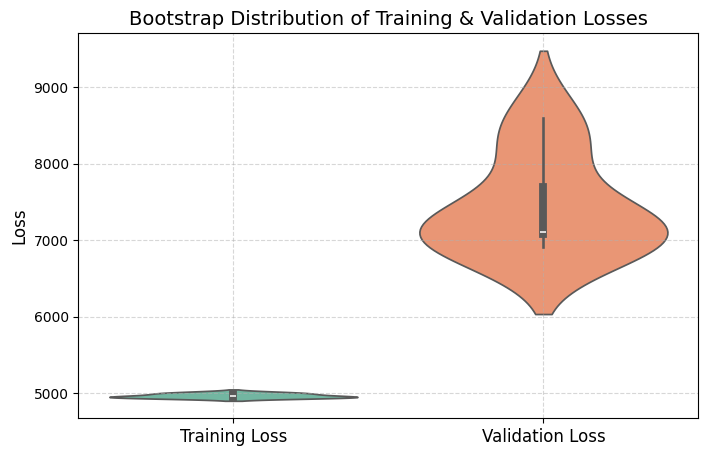

In [40]:

plt.figure(figsize=(8,5))
sns.violinplot(data=[unet_all_losses, unet_all_val_loss], inner="box", palette="Set2")
plt.xticks([0, 1], ["Training Loss", "Validation Loss"], fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Bootstrap Distribution of Training & Validation Losses", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()



In [27]:
# -----------------------------------------
# Save results for LaTeX table later
# -----------------------------------------
results = pd.DataFrame({
    "Metric": ["Training Loss", "Validation Loss"],
    "Mean": [train_summary[0], val_summary[0]],
    "Lower CI (2.5%)": [train_summary[1], val_summary[1]],
    "Upper CI (97.5%)": [train_summary[2], val_summary[2]]
})

print(results)
results.to_csv("./results/bootstrap_loss_summary.csv", index=False)


            Metric         Mean  Lower CI (2.5%)  Upper CI (97.5%)
0    Training Loss  4967.457450      4939.127661       5008.650073
1  Validation Loss  7449.773228      6935.271216       8528.435962


# Light-U-Net

# =============================
# Bootstrap Training Loop
# =============================

In [36]:

"""
Perform bootstrap training B times, track val_loss each run.
model_class: function returning a compiled model.
"""

B=100
epochs=10

l_all_val_losses = []
l_all_losses= []
for b in range(B):
    print(f"\n🔁 Bootstrap iteration {b+1}/{B}")

    train_tiles, train_labels_tiles ,  test_tiles , test_labels_tiles = prepare_dataset(categories, dic_tiles_by_sample , regions_tiles_by_sample )
    print(len(train_tiles) , len(train_labels_tiles) , len(test_tiles) , len(test_labels_tiles))
    X_train = np.array(train_tiles)
    X_test = np.array(test_tiles)
    # Load your ground truth labels accordingly here ⬇️
    y_train =  np.array(train_labels_tiles)  # <-- replace with actual GT
    y_test =  np.array(test_labels_tiles)   # <-- replace with actual GT

    # Create and train model
    history , model  =light_unet_train_(X_train, y_train , X_test, y_test  ,epochs )

    # Track final val_loss
    val_loss = history.history['val_loss'][-1]
    loss = history.history['loss'][-1]
    print(f"📉 Final val_loss (bootstrap {b+1}): {val_loss:.4f}")
    l_all_val_losses.append(val_loss)
    l_all_losses.append(loss)




🔁 Bootstrap iteration 1/100
low 303
medium 309
high 281
✅ Train samples: 713 (low, medium, high)
✅ Test samples: 400
✅ Train tiles: 25668, Test tiles: 14400
25668 25668 14400 14400
------------------------------
Creating and compiling the fully convolutional regression networks.
------------------------------
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 256, 256, 64) 576         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_141 (BatchN (None, 256, 256, 64) 256         conv2d_157[0

C:\Users\narges\AppData\Local\Temp\ipykernel_27400\2908956172.py:5: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,


Epoch 1/10
6417/6417 [==============================] - 295s 46ms/step - loss: 5760.8262 - val_loss: 7212.2710
Epoch 2/10
6417/6417 [==============================] - 289s 45ms/step - loss: 5104.9629 - val_loss: 7201.6670
Epoch 3/10
6417/6417 [==============================] - 290s 45ms/step - loss: 5063.8853 - val_loss: 6943.8262
Epoch 4/10
6417/6417 [==============================] - 287s 45ms/step - loss: 5052.5317 - val_loss: 7243.4453
Epoch 5/10
6417/6417 [==============================] - 284s 44ms/step - loss: 5036.4609 - val_loss: 7084.0356
Epoch 6/10
6417/6417 [==============================] - 284s 44ms/step - loss: 5027.1138 - val_loss: 7177.0127

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/10
6417/6417 [==============================] - 284s 44ms/step - loss: 5010.8057 - val_loss: 6977.1577
Epoch 8/10
6417/6417 [==============================] - 284s 44ms/step - loss: 4999.3403 - val_loss: 6920.0781
Epoch 9/10
6417/6417 [=========

KeyboardInterrupt: 

In [37]:
print(len(l_all_val_losses) , len(l_all_losses))

13 13


In [ ]:

# Summarize both losses
train_summary = summarize_results(l_all_losses, name="Training Loss")
val_summary = summarize_results(l_all_val_losses, name="Validation Loss")

## -----------------------------------------
# Visualization
# -----------------------------------------

Training Loss: Mean = 4982.0004, 95% CI = [4946.2340, 5021.9301]
Validation Loss: Mean = 7117.9132, 95% CI = [6865.9461, 7435.9618]


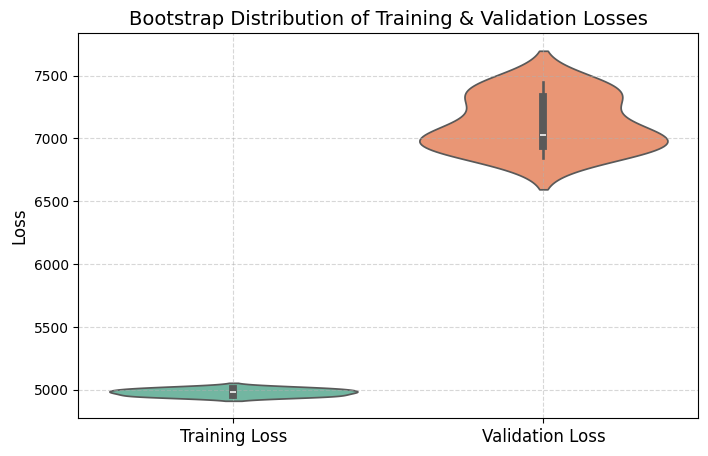

In [38]:

plt.figure(figsize=(8,5))
sns.violinplot(data=[l_all_losses, l_all_val_losses], inner="box", palette="Set2")
plt.xticks([0, 1], ["Training Loss", "Validation Loss"], fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Bootstrap Distribution of Training & Validation Losses", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()



In [39]:
# -----------------------------------------
# Save results for LaTeX table later
# -----------------------------------------
results = pd.DataFrame({
    "Metric": ["Training Loss", "Validation Loss"],
    "Mean": [train_summary[0], val_summary[0]],
    "Lower CI (2.5%)": [train_summary[1], val_summary[1]],
    "Upper CI (97.5%)": [train_summary[2], val_summary[2]]
})

print(results)
results.to_csv("./results/light_unet_bootstrap_loss_summary.csv", index=False)


            Metric         Mean  Lower CI (2.5%)  Upper CI (97.5%)
0    Training Loss  4982.000413      4946.234033       5021.930078
1  Validation Loss  7117.913236      6865.946094       7435.961816
